# Import dependencies

In [32]:
# Base libraries
import os
import time
import glob
import copy
import gc
import shutil
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Multiprocessing
from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor

# Data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pytorch for neural network architecutre
!pip install -qU timm
import torch
import timm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

# Data preparation for deep learning
from sklearn.model_selection import train_test_split

# Viewing images and extracting metadata
import cv2
!pip install -qU python-gdcm pylibjpeg
import pydicom
import gdcm
import pylibjpeg
import PIL
from PIL import Image
import cython

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load in the data

In [34]:
train_data = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")
train_data = train_data.set_index('image_id', drop = False)
train_data.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
image_id,,,,,,,,,,,,,,
462822612,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1459541791,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
1864590858,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
1874946579,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
220375232,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [35]:
# Extracting image paths
train_paths = []

for idx in list(train_data.index):
    image_path = os.path.join("/kaggle/input/rsna-breast-cancer-detection/train_images",
                              str(train_data.loc[idx, "patient_id"]),
                              str(idx) + ".dcm")
    train_paths.append(image_path)

# Exploratory data analysis

## Number of images per patient

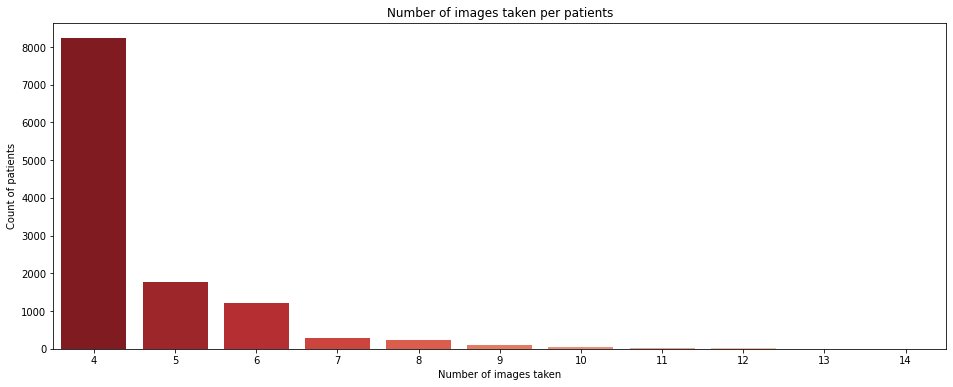

In [36]:
n_images_per_patient = train_data['patient_id'].value_counts()
plt.figure(figsize=(16, 6))
sns.countplot(n_images_per_patient, palette='Reds_r')
plt.title("Number of images taken per patients")
plt.xlabel('Number of images taken')
plt.ylabel('Count of patients')
plt.show()

## Image features in the dataset

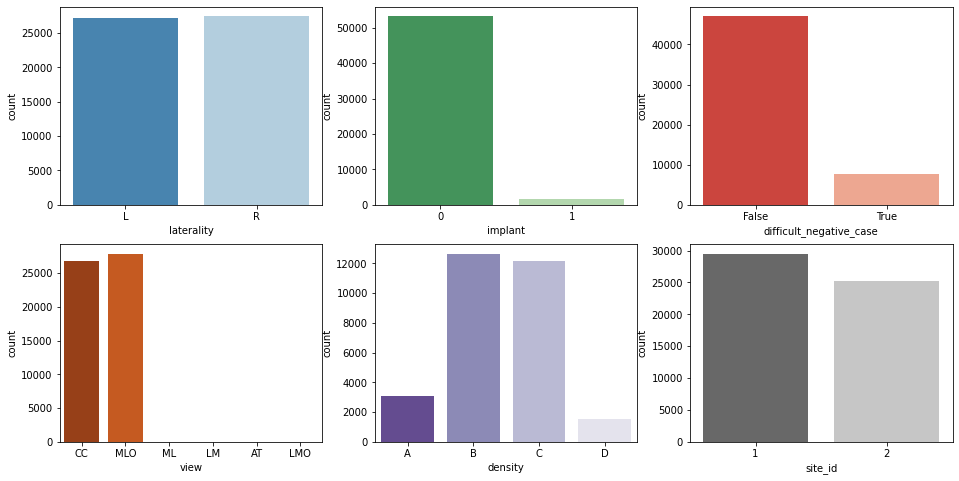

In [37]:
fig, ax = plt.subplots(2, 3, figsize=(16, 8))
sns.countplot(train_data['laterality'], palette='Blues_r', ax=ax[0, 0])
sns.countplot(train_data['implant'], palette='Greens_r', ax=ax[0, 1])
sns.countplot(train_data['difficult_negative_case'], palette='Reds_r', ax=ax[0, 2])
sns.countplot(train_data['view'], palette='Oranges_r', ax=ax[1, 0])
sns.countplot(train_data['density'], palette='Purples_r', order=['A', 'B', 'C', 'D'], ax=ax[1, 1])
sns.countplot(train_data['site_id'], palette='Greys_r', ax=ax[1, 2])
plt.show()

In [38]:
print(f"Total number of patients in dataset: {len(set(train_data['patient_id']))}\n")

print(f"Total number of images in dataset: {len(train_data)}\n")

print(f"Number of missing values in each column:\n{[(col, sum(pd.isna(train_data[col]))) for col in train_data.columns]}\n")

print(f"Number of cancerous mammograms: {sum(train_data['cancer'] == 1)} / {len(train_data) - sum(pd.isna(train_data['cancer']))}\n")

print(f"Number of images that had associated biopsies: {sum(train_data['biopsy'] == 1)} / {len(train_data) - sum(pd.isna(train_data['biopsy']))}\n")

print(f"Number of images that belonged to patients with implants: {sum(train_data['implant'] == 1)} / {len(train_data) - sum(pd.isna(train_data['implant']))}\n")

print(f"Number of images with difficult negative diagnosis: {sum(train_data['difficult_negative_case'] == 1)} / {len(train_data) - sum(pd.isna(train_data['difficult_negative_case']))}\n")

print(f"Patient breast density distribution:\n{train_data['density'].value_counts()}\n")

print(f"Patient age distibution:\n{train_data['age'].describe()}\n")

cont_table = pd.crosstab(index = train_data['density'], columns = train_data['difficult_negative_case'])
print(f"Relationship between breast density and ease of diagnosis:\n {cont_table}\n")

cont_table = pd.crosstab(index = train_data['density'], columns = train_data['cancer'])
print(f"Relationship between breast density and cancer:\n {cont_table}\n")

cont_table = pd.crosstab(index = train_data['biopsy'], columns = train_data['cancer'])
print(f"Relationship between biopsy and cancer:\n {cont_table}")

Total number of patients in dataset: 11913

Total number of images in dataset: 54706

Number of missing values in each column:
[('site_id', 0), ('patient_id', 0), ('image_id', 0), ('laterality', 0), ('view', 0), ('age', 37), ('cancer', 0), ('biopsy', 0), ('invasive', 0), ('BIRADS', 28420), ('implant', 0), ('density', 25236), ('machine_id', 0), ('difficult_negative_case', 0)]

Number of cancerous mammograms: 1158 / 54706

Number of images that had associated biopsies: 2969 / 54706

Number of images that belonged to patients with implants: 1477 / 54706

Number of images with difficult negative diagnosis: 7705 / 54706

Patient breast density distribution:
B    12651
C    12175
A     3105
D     1539
Name: density, dtype: int64

Patient age distibution:
count    54669.000000
mean        58.543928
std         10.050884
min         26.000000
25%         51.000000
50%         59.000000
75%         66.000000
max         89.000000
Name: age, dtype: float64

Relationship between breast density an

## Machine IDs

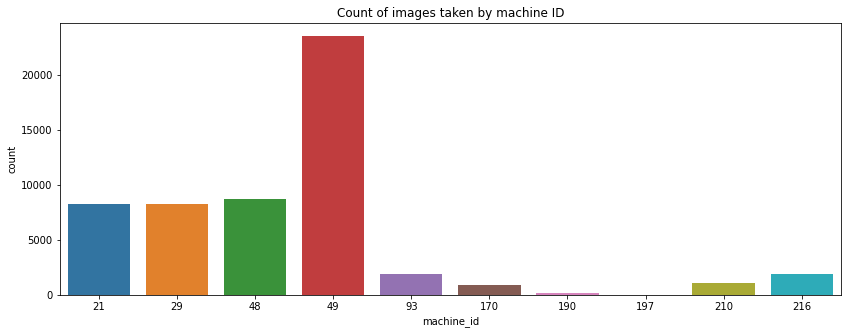

In [39]:
plt.figure(figsize=(14, 5))
sns.countplot(train_data['machine_id'])
plt.title("Count of images taken by machine ID")
plt.show()

## Difference in images produced by different machines

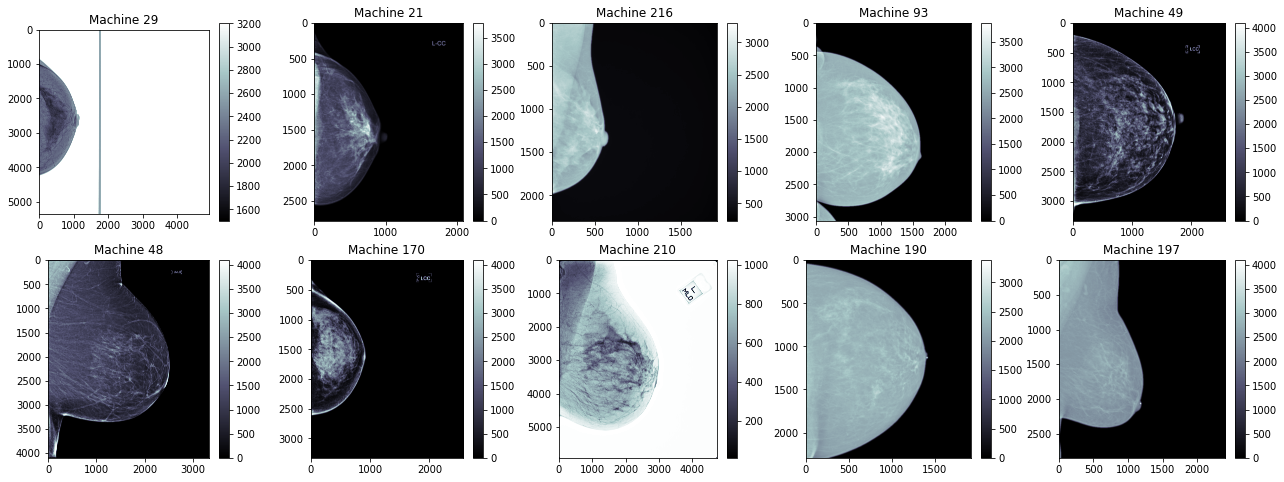

In [40]:
machine_ids = train_data['machine_id'].unique()

plt.figure(figsize=(22, 8))
for i, m_id in enumerate(machine_ids):
    indices = list(train_data['machine_id'] == m_id)
    image_paths = pd.Series(train_paths)[indices]
    image_paths = image_paths.reset_index(drop = True)
    scan =  pydicom.dcmread(image_paths[0])
    plt.subplot(2, 5, i+1)
    plt.imshow(scan.pixel_array, cmap='bone')
    plt.title(f"Machine {m_id}")
    plt.colorbar()
    plt.grid(False)
plt.show()

# Preprocessing images

## Sample image

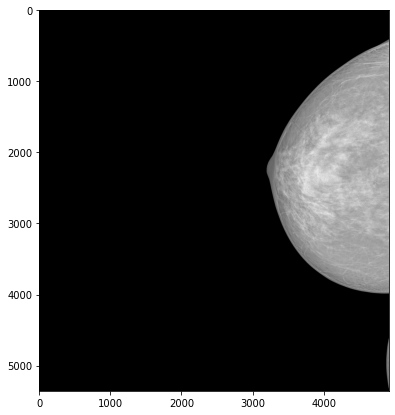

In [41]:
sample_path = train_paths[10]

dicom = pydicom.dcmread(sample_path)
img = dicom.pixel_array

img = (img - img.min()) / (img.max() - img.min())

if dicom.PhotometricInterpretation == "MONOCHROME1":
    img = 1 - img

plt.figure(figsize=(7, 7))
plt.imshow(img, cmap="gray")
plt.show()

## Preprocess to .png format images

inspired by this link: https://www.kaggle.com/code/theoviel/dicom-resized-png-jpg

We use multiprocessing (parallel and concurrent computation in the CPU cores) to speed up the conversions.

In [42]:
def process_to_png(path, size = 512, save_folder = "", extension = "png"):
    
    img_id = os.path.splitext(os.path.basename(path))[0]
    
    dicom = pydicom.dcmread(path)
    img = dicom.pixel_array
    
    img = (img - img.min()) / (img.max() - img.min())
    
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        img = 1 - img
    
    img = cv2.resize(img, (size, size))
    
    cv2.imwrite(f"{save_folder}{img_id}.{extension}", (img * 255).astype(np.uint8))

In [ ]:
os.makedirs("/kaggle/working/processed_to_png")

In [ ]:
_ = Parallel(n_jobs = 4)(
    delayed(process_to_png)(path,
                            size = 512,
                            save_folder = "/kaggle/working/processed_to_png/",
                            extension = "png")
    for path in tqdm(train_paths)
)

## Cut off empty spaces from images

inspired by this link: https://www.kaggle.com/code/vslaykovsky/rsna-cut-off-empty-space-from-images

In [43]:
processed_to_png_imgs = os.listdir("/kaggle/working/processed_to_png/")
train_processed_paths = ["/kaggle/working/processed_to_png/" + path for path in processed_to_png_imgs]

In [ ]:
os.makedirs("/kaggle/working/processed_to_fit")

In [44]:
def fit_image(path, target_dir, size = 512):
    
    img = cv2.imread(path)
    img_id = os.path.basename(path)
    
    img = img[5:-5, 5:-5]
    
    output = cv2.connectedComponentsWithStats((img > 15).astype(np.uint8)[:, :, 0],
                                              8,
                                              cv2.CV_32S
                                             )
    
    stats = output[2]
    
    idx = stats[1:, 4].argmax() + 1
    x1, y1, w, h = stats[idx][:4]
    x2 = x1 + w
    y2 = y1 + h
    
    img_fit = img[y1:y2, x1:x2]
    img_fit = cv2.resize(img_fit, (size, size))
    
    cv2.imwrite(f"{target_dir}{img_id}", img_fit[:, :, 0])

In [ ]:
with ProcessPoolExecutor(4) as p:
    for i in tqdm(
        p.map(
            fit_image,
            train_processed_paths
        ),
        total = len(train_processed_paths)
    ):
        pass

# Countering the data imbalance problem

## Form train / validation set

## Rationale:
Using the most similar controls to the cases (difficult classifications) would better train the model while ensuring that other features that may affect mammogram quality or cancer probability are similarly distributed between cases and controls.

### Methods:

**1. Using non-cancerouse mammograms from the patients that have cancerous mammogram:** This would ensure that the control mammogram is matched in every other way to the case mammogram. We will take the following steps:
1. Separate the val set. The val set must have the same proportion of cancerous mammograms as the original dataset.
* The train/val split must be performed based on patients, not image_ids. This is because if a CC view of a mammogram is in the train set while its MLO view is in the val set, this constitutes data leakage.
2. Extract all the left and right mammograms for patients that have cancer and shuffle them. Thankfully, we have almost the same number of left (248) and right (244) cancerous mammograms
2. Increase image augmentation random horizontal flip to make sure the model sees all 

#### 1. Separate train and val sets

In [45]:
cancer_patient = []

for patient in train_data['patient_id'].unique():
    subset = train_data[train_data['patient_id'] == patient]
    if 1 in subset['cancer'].values:
        cancer_patient.append(1)
    else:
        cancer_patient.append(0)

In [46]:
patient_dataset = pd.DataFrame({
    'patients' : train_data['patient_id'].unique(),
    'cancer' : cancer_patient
})

patient_dataset.head()

,patients,cancer
0,10006,0
1,10011,0
2,10025,0
3,10038,0
4,10042,0


In [47]:
train_patients, val_patients = train_test_split(patient_dataset,
                                                test_size = 0.04,
                                                shuffle = True,
                                                stratify = patient_dataset['cancer'],
                                                random_state = 42
                                               )

In [48]:
val_paths = []
val_labels = []

for patient in val_patients['patients']:
    
    subset = train_data[train_data['patient_id'] == patient]
    
    val_images = list(subset["image_id"])
    val_labels = val_labels + list(subset["cancer"])
    
    for img in val_images:
        path = "/kaggle/working/processed_to_fit/" + str(img) + ".png"
        val_paths.append(path)

### 2. Form train set from cancerous patients in train_patients

In [49]:
train_patients = train_patients[train_patients['cancer'] == 1]

train_paths = []
train_labels = []

for patient in train_patients['patients']:
    
    subset = train_data[train_data['patient_id'] == patient]
    
    train_images = list(subset["image_id"])
    train_labels = train_labels + list(subset["cancer"])
    
    for img in train_images:
        path = "/kaggle/working/processed_to_fit/" + str(img) + ".png"
        train_paths.append(path)

# Form dataloader

In [50]:
class MammogramSet(Dataset):
    
    def __init__(self, img_paths, img_labels = None, transform = None):
        super().__init__()
        self.img_paths = img_paths
        self.img_labels = img_labels
        self.transform = transform
    
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        
        img_path = self.img_paths[idx]
        
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as ex:
            print(path, ex)
            return None

        if self.transform is not None:
            img = self.transform(img)
            
        if self.img_labels is not None:
            label = self.img_labels[idx]
            return img, label

        return img

In [51]:
train_transform = transforms.Compose([
    transforms.Resize((320, 320), interpolation = transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(degrees=(-5, 5)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]
)

val_transform = transforms.Compose([
    transforms.Resize((384, 384), interpolation = transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]
)

In [52]:
train_dataset = MammogramSet(img_paths = train_paths, img_labels = train_labels, transform = train_transform)

val_dataset = MammogramSet(img_paths = val_paths, img_labels = val_labels, transform = val_transform)

In [53]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 2, drop_last = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False, num_workers = 2, drop_last = True)

Batch shape: torch.Size([16, 3, 320, 320])
Image tensor data type: torch.cuda.FloatTensor
Label tensor data type: torch.cuda.LongTensor
Image tensor device: cuda:0
Batch labels: [0 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0]


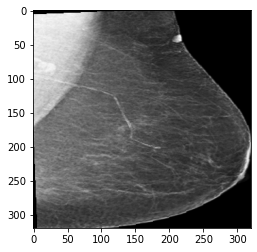

In [54]:
# Sample batch
for i, (images,labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    break
        
print("Batch shape:", images.shape)
print("Image tensor data type:", images[0].type())
print("Label tensor data type:", labels[0].type())
print("Image tensor device:", images[0].device)
print('Batch labels:', labels.cpu().numpy())
plt.imshow((np.transpose(images[0].cpu().numpy(), (1,2,0)))[:, :, 0], cmap = 'gray')
plt.grid(False)

# Create model

We'll use transfer learning:
1. Import model from Timm.
2. Change the classifier layer to a custom head.
3. Define the probabilistic F1-score loss function.

In [55]:
model = timm.create_model('efficientnet_b4',
                          pretrained = True, 
                          num_classes = 1,
                          global_pool = 'catavgmax'
                         )

In [56]:
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b4_ra2_320-7eb33cd5.pth',
 'num_classes': 1000,
 'input_size': (3, 320, 320),
 'pool_size': (10, 10),
 'crop_pct': 1.0,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv_stem',
 'classifier': 'classifier',
 'test_input_size': (3, 384, 384),
 'architecture': 'efficientnet_b4'}

In [57]:
num_in_features = model.get_classifier().in_features

model.classifier = nn.Sequential(
    nn.BatchNorm1d(num_in_features),
    nn.Linear(in_features = num_in_features, out_features = 512, bias = False),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.4),
    nn.Linear(in_features = 512, out_features = 128, bias = False),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(0.4),
    nn.Linear(in_features = 128, out_features = 1),
)

model = model.to(device)

In [58]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.classifier.parameters())

In [59]:
def pfbeta(labels, predictions, beta = 1.):
    
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / max(y_true_count, 1)  # avoid / 0
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

# Train model

To improve model performance, we use:
1. Automatic mixed precision for GPU optimization. Scale gradients to prevent them from vanishing (values that are too small not being able to be represented in 16bit precision).
2. OneCycleLr learning rate scheduler.

In [60]:
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []
    
def train_model(model, criterion, optimizer, num_epochs = 3):
    
    torch.manual_seed(42)
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    
    torch.backends.cudnn.benchmark = True
    
    scaler = torch.cuda.amp.GradScaler()
    
#     scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.1, epochs = num_epochs,
#                                                     steps_per_epoch = len(train_loader))
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
                dataset = train_dataset
                dataloader = train_loader
            else:
                model.eval()
                dataset = val_dataset
                dataloader = val_loader

            running_loss = 0.0
            running_preds = torch.empty(0).to(device)
            running_labels = torch.empty(0).to(device)

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.float().to(device)
                
                if phase == 'train':
                    optimizer.zero_grad()
                    
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    outputs = torch.squeeze(outputs)
                    loss = criterion(outputs, labels)

                if phase == 'train':
#                     loss.backward()
#                     optimizer.step()
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                                                    
#                     scheduler.step()
                                            
                    scaler.update()

                preds = (torch.sigmoid(outputs) > 0.5).float()
                running_loss += loss.item() * inputs.size(0)
                running_labels = torch.cat([running_labels, labels])
                running_preds = torch.cat([running_preds, preds])
                
#                 gc.collect()
#                 torch.cuda.empty_cache()

            epoch_loss = running_loss / len(dataset)
            epoch_f1 = pfbeta(running_labels.cpu(), running_preds.cpu())

            print('{} loss: {:.4f}, f1: {:.4f}'.format(phase, epoch_loss, epoch_f1))
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_f1s.append(epoch_f1)
            else:
                val_losses.append(epoch_loss)
                val_f1s.append(epoch_f1)
                
            if phase == 'validation' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val F1 score: {best_f1:4f}')
    
    return model

In [62]:
epochs = 10

model_trained = train_model(model, criterion, optimizer, num_epochs = epochs)

Epoch 1/10
----------
train loss: 0.6668, f1: 0.5637
validation loss: 0.6770, f1: 0.0485
Epoch 2/10
----------
train loss: 0.7108, f1: 0.5342
validation loss: 0.4919, f1: 0.0544
Epoch 3/10
----------
train loss: 0.6940, f1: 0.5514
validation loss: 0.7210, f1: 0.0389
Epoch 4/10
----------
train loss: 0.6916, f1: 0.5496
validation loss: 0.8869, f1: 0.0369
Epoch 5/10
----------
train loss: 0.6891, f1: 0.5581
validation loss: 0.6570, f1: 0.0358
Epoch 6/10
----------
train loss: 0.6848, f1: 0.5599
validation loss: 0.5397, f1: 0.0647
Epoch 7/10
----------
train loss: 0.6819, f1: 0.5683
validation loss: 0.7532, f1: 0.0343
Epoch 8/10
----------
train loss: 0.6849, f1: 0.5585
validation loss: 0.7749, f1: 0.0289
Epoch 9/10
----------
train loss: 0.6788, f1: 0.5641
validation loss: 0.5258, f1: 0.0368
Epoch 10/10
----------
train loss: 0.6776, f1: 0.5877
validation loss: 0.4925, f1: 0.0616
Training complete in 11m 6s
Best val F1 score: 0.064655


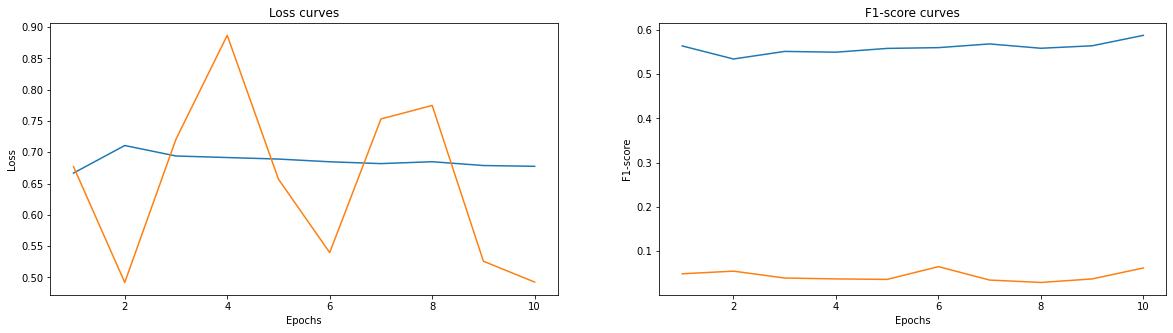

In [63]:
# Plot loss and metric curves
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].plot(range(1, epochs + 1), train_losses, label = 'Training loss')
ax[0].plot(range(1, epochs + 1), val_losses, label = 'Validation loss')
ax[0].set_title('Loss curves')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(range(1, epochs + 1), train_f1s, label = 'Training F1-score')
ax[1].plot(range(1, epochs + 1), val_f1s, label = 'Validation F1-score')
ax[1].set_title('F1-score curves')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('F1-score')
plt.show()

In [ ]:
torch.save(model_trained, "model_control_matched_20_epoch.pt")